In [122]:
#hide
#default_exp visualization.experiment_visualization
from nbdev.showdoc import *
from dsblocks.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Visualization utils

In [123]:
#export
import numpy as np
#import matplotlib.pyplot as plt
import os
import pickle
import joblib
import pandas as pd
from IPython.display import display
import visdom
from hpsearch.config.hpconfig import get_path_results, get_path_experiments, get_experiment_manager
import hpsearch.utils.experiment_utils as ut
from hpsearch.visualization import plot_utils 
import warnings
warnings.filterwarnings('ignore')

In [124]:
#for tests
import pytest
from dsblocks.utils.nbdev_utils import md
from hpsearch.examples.dummy_experiment_manager import generate_data
from hpsearch.examples.dummy_experiment_manager import run_multiple_experiments

In [125]:
#exports tests.visualization.test_experiment_visualization
def generate_data_plot (folder):
    em = generate_data (folder)
    run_multiple_experiments (em=em, nruns=5, noise=0.1, rate=0.1, verbose=False)
    
    return em

## Plot history

### MultiHistoryPlotter

In [126]:
#export
class MultiHistoryPlotter ():
    def __init__ (self, experiments=None, run_number=0, path_experiments=None, 
                  metrics='all', metrics_second=None, parameters = None, compare = True,  
                  ylegend=0.5, name_file='model_history.pk', op='max', 
                  include_parameters_in_legend=False, backend='visdom', 
                  use_run_number_in_label=True, use_run_number_in_title=False, 
                  write_scores_in_title=True, **kwargs):
        self.experiments = experiments
        self.run_number = run_number
        self.path_experiments = path_experiments
        if path_experiments is not None:
            em = get_experiment_manager ()
            em.set_path_experiments (path_experiments=path_experiments)
        self.metrics = metrics
        self.metrics_second = [] if metrics_second is None else metrics_second
        self.parameters = parameters
        self.compare = compare
        self.ylegend = ylegend
        self.name_file = name_file
        self.op = op
        self.include_parameters_in_legend = include_parameters_in_legend
        self.backend = backend
        if self.path_experiments is None:
            self.path_experiments = get_path_experiments()
        self.use_run_number_in_label = use_run_number_in_label
        self.use_run_number_in_title = use_run_number_in_title
        self.write_scores_in_title = write_scores_in_title
    
    def plot_multiple_histories (self, experiments=None, run_number=None, metrics=None, 
                                 metrics_second=None):
        self.experiments = experiments if experiments is not None else self.experiments
        assert self.experiments is not None, ('experiments needs to be indicated, '
                                              'either at construction time or in this call')
        self.run_number = run_number if run_number is not None else self.run_number
        self.metrics = metrics if metrics is not None else self.metrics
        self.metrics_second = metrics_second if metrics_second is not None else self.metrics_second
        
        df = pd.read_csv(f'{self.path_experiments}/experiments_data.csv', index_col=0)
        df = ut.replace_with_default_values (df)
        df2 = ut.get_experiment_parameters (df.loc[self.experiments], only_not_null=True)
        parameters2, df2 = ut.get_parameters_unique(df2)

        if self.compare or self.parameters is not None:        
            if self.parameters is None:
                self.parameters = parameters2 
            df = df.loc[self.experiments, self.parameters]

        if type(self.metrics)==str and (self.metrics == 'all'):
            path_results = get_path_results (self.experiments[0], run_number=self.run_number)
            history = joblib.load (f'{path_results}/{self.name_file}')
            self.metrics = history.keys()
        if type(self.metrics) == str:
            self.metrics = [self.metrics]
        if type(self.metrics_second) == str:
            self.metrics_second = [self.metrics_second]

        df_show = df.copy()
        run_numbers = self.run_number if isinstance(self.run_number, list) else [self.run_number]
        use_run_number_in_label = ((self.use_run_number_in_label or len(run_numbers) > 0) 
                                   and len(self.experiments) < 2)
        use_run_number_in_title = ((self.use_run_number_in_title or len(run_numbers) > 0)
                                   and len(self.experiments) < 2)
        for (imetric, metric) in enumerate(self.metrics):
            if imetric==0 and len(self.metrics_second)>0:
                title = ''
            else:
                title = metric
            traces = []
            for experiment_id in self.experiments:
                for run_number in run_numbers:
                    if run_number == 'mean':
                        history = self.obtain_average_history ([metric] + self.metrics_second, 
                                                               experiment_id)
                    else:
                        history = None
                    traces, title, history = self.plot_metric (
                        metric, experiment_id=experiment_id, run_number=run_number, imetric=imetric, 
                        traces=traces, title=title, df_show=df_show, df2=df2, history=history, 
                        use_run_number_in_label=use_run_number_in_label, 
                        use_run_number_in_title=use_run_number_in_title)
                    
                    if (imetric == 0):
                        for metric_second in self.metrics_second:
                            traces, title, history = self.plot_metric (
                                metric_second, experiment_id=experiment_id, run_number=run_number, 
                                imetric=imetric, traces=traces, title=title, df_show=df_show, 
                                df2=df2, history=history, 
                                use_run_number_in_label=use_run_number_in_label,
                                use_run_number_in_title=use_run_number_in_title)

            plot_utils.plot(title=title, xlabel='epoch', ylabel=metric, traces=traces, 
                            backend=self.backend)
            if self.backend=='visdom':
                vis = visdom.Visdom()
                vis.text (df_show.to_html(justify='left', col_space=100), win= f'{metric}_parameters')
            display(df2)
            
    def plot_metric (self, metric, experiment_id=None, run_number=None, imetric=0, traces=None, 
                     title=None, df_show=None, df2=None, history=None, path_results=None,
                     use_run_number_in_label=True, use_run_number_in_title=False):
        if history is None:
            if experiment_id is None or run_number is None:
                raise ValueError ('if history is None, experiment_id and run_number must be '
                                  'introduced')
            if path_results is None:
                path_results = get_path_results (experiment_id, run_number=run_number)
            path_history = f'{path_results}/{self.name_file}'
            if os.path.exists(path_history):
                history = joblib.load (path_history)
            else:
                return traces, title, None
        traces, title = self.plot_history (history, metric, experiment_id=experiment_id, 
                                           run_number=run_number, imetric=imetric, traces=traces, 
                                           title=title, df_show=df_show, df2=df2, 
                                           use_run_number_in_label=use_run_number_in_label,
                                           use_run_number_in_title=use_run_number_in_title)
        return traces, title, history

    def plot_history (self, history, metric, experiment_id=None, run_number=None, 
                      imetric=0, traces=None, title=None, df_show=None, df2=None,
                      use_run_number_in_label=True, use_run_number_in_title=False):
        title = '' if title is None else title
        if experiment_id is not None and not use_run_number_in_label:
            number = experiment_id
        elif use_run_number_in_label and run_number is not None:
            number = run_number
        else:
            number = None
        if number is not None:
            if self.compare and self.include_parameters_in_legend and experiment_id is not None:
                scores = list(dict(df.loc[experiment_id]).values())
                label = f'{number}-{scores}'
            else:
                if (imetric==0) and (len(self.metrics_second)>0):
                    label = f'{number} ({metric})'
                else:
                    label = f'{number}'
        else:
            label = ''
        traces = plot_utils.add_trace (history[metric], style='A.-', label=label, backend=self.backend, 
                                       traces=traces)
        if self.op == 'min':
            imin = int(np.array(history[metric]).argmin())
        else:
            imin = int(np.array(history[metric]).argmax())
        vmin = float(history[metric][imin])
        traces = plot_utils.add_trace ([imin], [vmin], style='A.', label=None, backend=self.backend, 
                                       marker={'color': 'red', 'symbol': 104, 'size': 10},
                                       traces=traces)
        if experiment_id is not None and not use_run_number_in_title:
            number = experiment_id
        elif use_run_number_in_title and run_number is not None:
            number = run_number
        else:
            number = None
        if (number is not None) and self.write_scores_in_title:
            if (imetric==0) and (len(self.metrics_second)>0):
                title += f' [{number} ({metric}): {vmin:.3}]'
            else:
                title += f' [{number}]: {vmin:.3}'
        if experiment_id is not None:
            if df_show is not None: df_show.loc[experiment_id, metric] = vmin
            if df2 is not None: df2.loc[experiment_id, metric] = vmin
        return traces, title

    def obtain_average_history (self, metrics, experiment_id):
        run_number = 0
        avg_history = None
        while True:
            path_results = get_path_results (experiment_id, run_number=run_number)
            path_history = f'{path_results}/{self.name_file}'
            if os.path.exists (path_history):
                history = joblib.load (path_history)
                if avg_history is None:
                    avg_history = {k:np.array(history[k]) for k in metrics}
                else:
                    k = metrics[0]
                    n = min(len(avg_history[k]), len(history[k]))
                    avg_history = {k:avg_history[k][:n]+history[k][:n] for k in metrics}
            else:
                break
            run_number += 1
        avg_history = {k:avg_history[k]/run_number for k in metrics}
        
        return avg_history

### plot_multiple_histories

In [127]:
#export
def plot_multiple_histories (experiments, **kwargs):
    multi_history_plotter = MultiHistoryPlotter (**kwargs)
    multi_history_plotter.plot_multiple_histories (experiments=experiments)
    return multi_history_plotter

### usage

In [129]:
#exports tests.visualization.test_experiment_visualization
def test_plot_history ():
    em = generate_data_plot ('plot_history')
    
    md ('Plot all the metrics that have been stored in model_history')
    plot_multiple_histories ([8, 16], run_number=0, op='max', backend='matplotlib')
    
    md ('Plot only one metric, and three experiments')
    md ('We plot the test_accuracy metric')
    plot_multiple_histories ([8, 12, 16], run_number=0, op='max', metrics = 'test_accuracy', 
                             backend='matplotlib')
    
    md ('Plot two metrics in same figure')
    plot_multiple_histories (experiments=[8], run_number=0, op='max', metrics = 'test_accuracy', 
                             metrics_second = ['validation_accuracy'], backend='matplotlib')
    
    md ('Use plotly as backend')
    plot_multiple_histories ([8, 12, 16], run_number=0, op='max', metrics = 'test_accuracy', 
                             backend='plotly')
    
    em.remove_previous_experiments (parent=True)

running test_plot_history


Plot all the metrics that have been stored in model_history

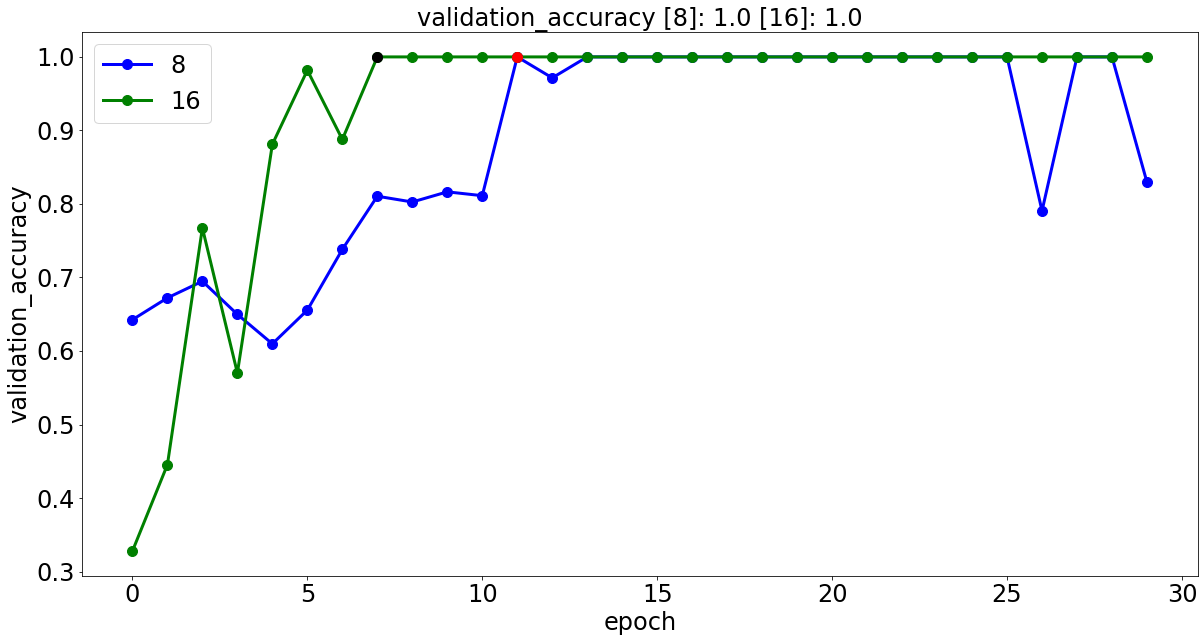

,offset,rate,validation_accuracy
8,0.6,0.03,1.0
16,0.3,0.10,1.0


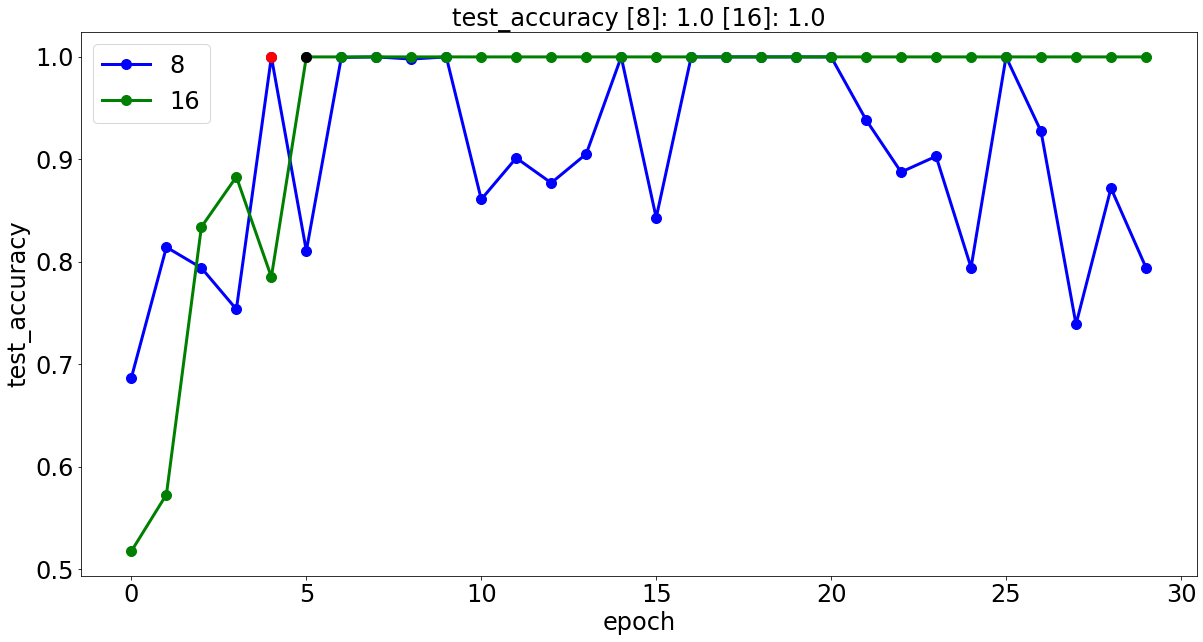

,offset,rate,validation_accuracy,test_accuracy
8,0.6,0.03,1.0,1.0
16,0.3,0.10,1.0,1.0


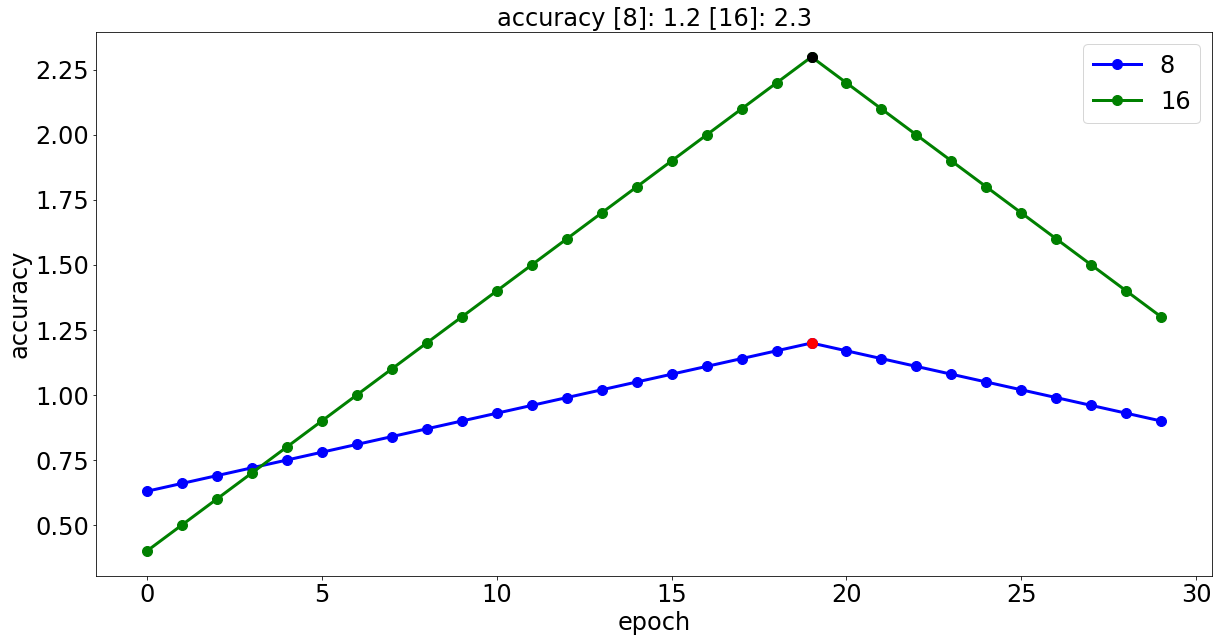

,offset,rate,validation_accuracy,test_accuracy,accuracy
8,0.6,0.03,1.0,1.0,1.2
16,0.3,0.10,1.0,1.0,2.3


Plot only one metric, and three experiments

We plot the test_accuracy metric

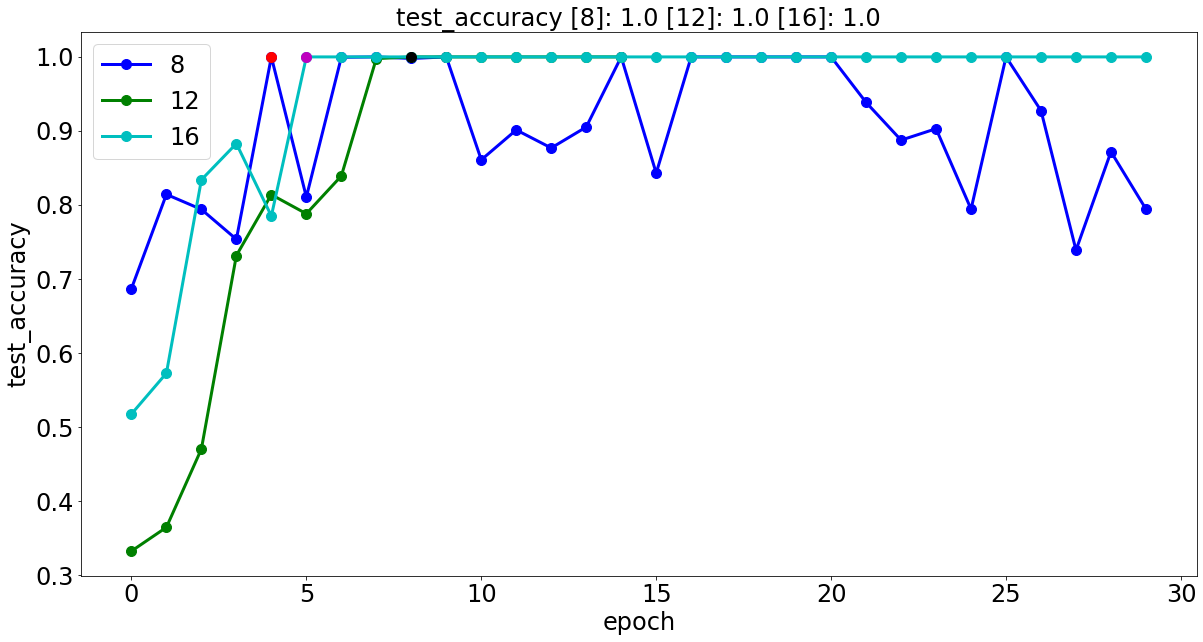

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


Plot seveal metrics in same figure

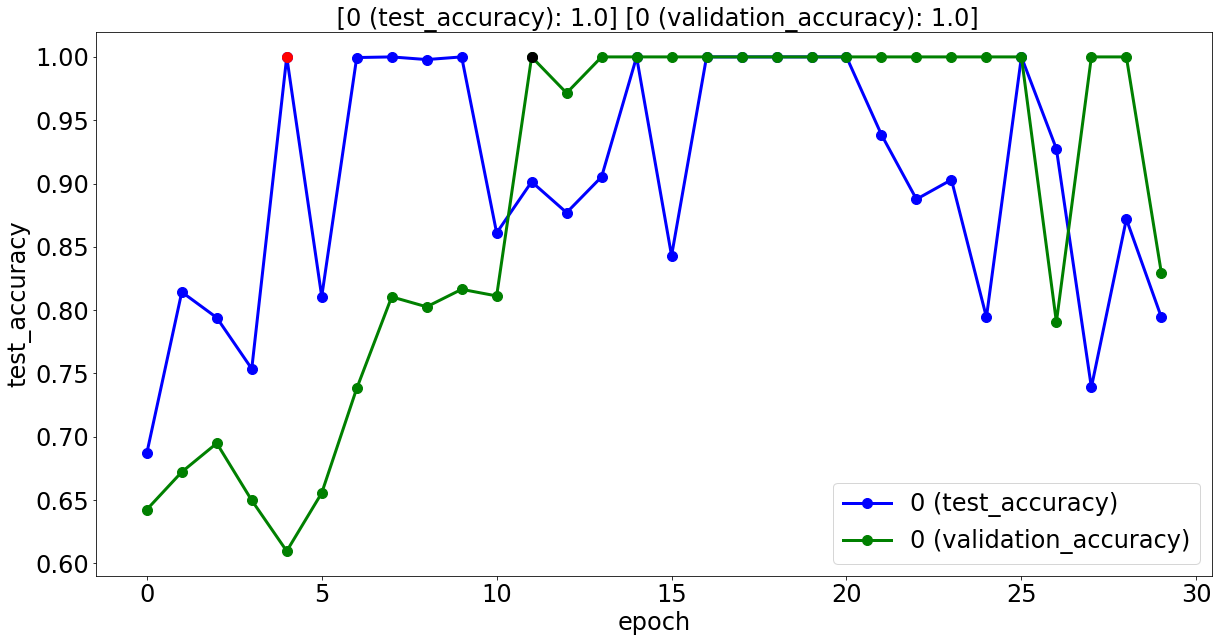

,test_accuracy,validation_accuracy
8,1.0,1.0


Use plotly as backend

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [130]:
tst.run (test_plot_history, tag='dummy')

### Plotting multiple runs

In [117]:
#exports tests.visualization.test_experiment_visualization
def test_multiple_runs ():
    em = generate_data_plot ('multiple_runs')

    md ('#### calling plot_metric directly')
    multi_history_plotter = MultiHistoryPlotter (backend='matplotlib')
    traces, title, history = multi_history_plotter.plot_metric ('test_accuracy', 8, run_number=1);
    plot_utils.plot(title=title, xlabel='epoch', ylabel='test_accuracy', traces=traces, 
                    backend='matplotlib');

    md ('#### calling obtain_average_history and plot_history')
    history = multi_history_plotter.obtain_average_history (['test_accuracy'], 8)
    traces, title = multi_history_plotter.plot_history (history, 'test_accuracy', run_number='mean',
                                                        traces=traces);
    plot_utils.plot(title=title, xlabel='epoch', ylabel='test_accuracy', traces=traces, 
                    backend='matplotlib');

    md ('#### plotting multiple runs, and indicating a different path_experiments')
    import shutil
    shutil.move ('test_multiple_runs', 'test_another_location')
    multi_history_plotter = MultiHistoryPlotter (path_experiments='test_another_location', 
                                                 backend='matplotlib')
    multi_history_plotter.plot_multiple_histories (experiments=[8], run_number=list(range(5))+['mean'], 
                                                   metrics='test_accuracy')
    shutil.move ('test_another_location', 'test_multiple_runs')
    em.remove_previous_experiments (parent=True)

running test_multiple_runs


#### calling plot_metric directly

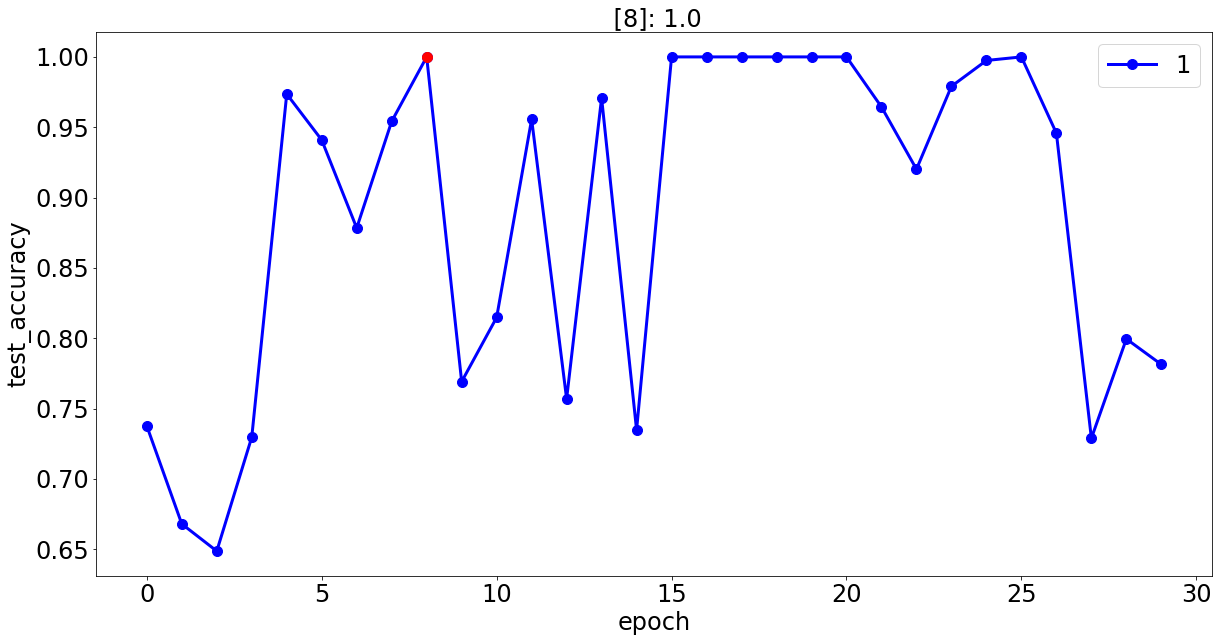

#### calling obtain_average_history and plot_history

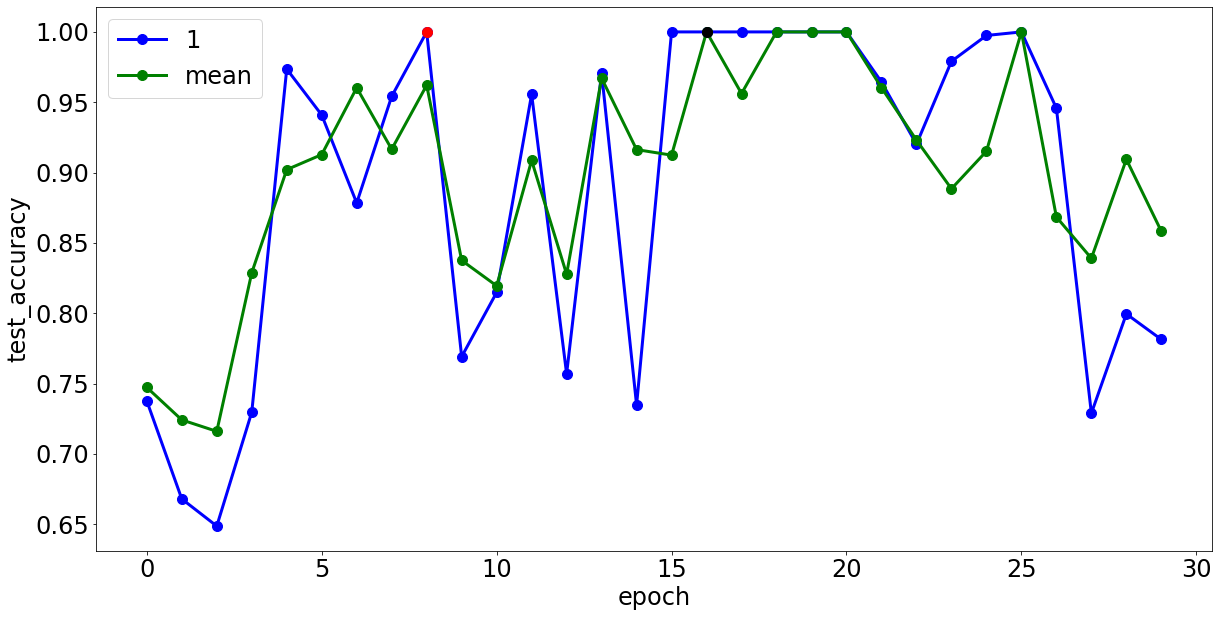

#### plotting multiple runs, and indicating a different root_path

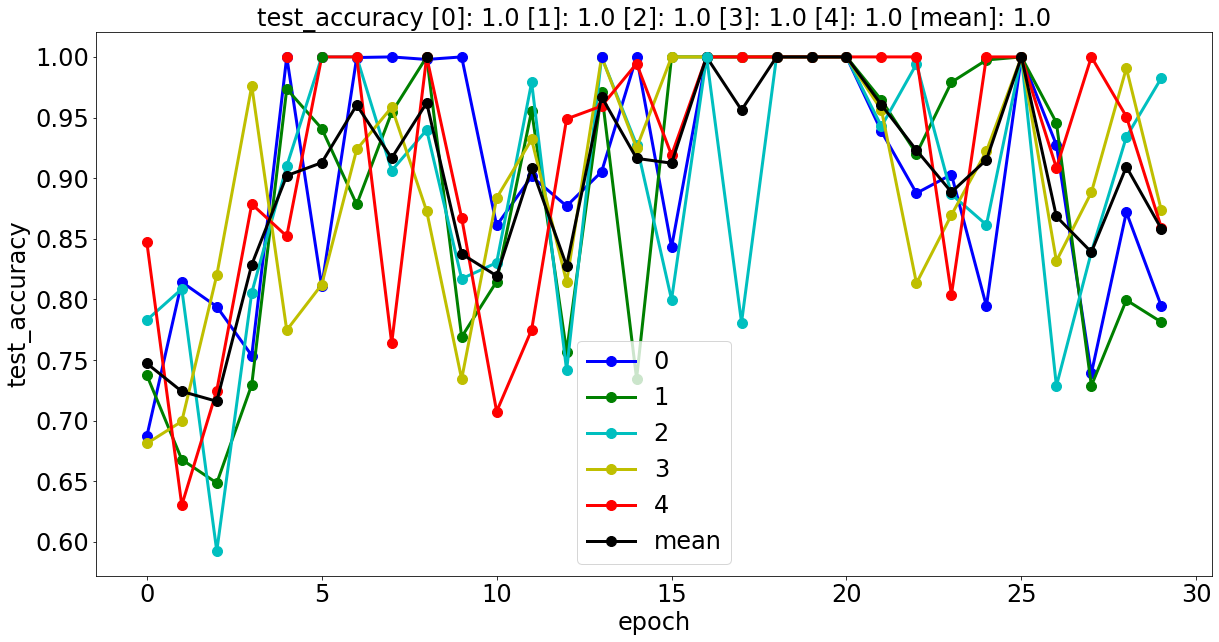

,test_accuracy
8,1.0


In [118]:
tst.run (test_multiple_runs, tag='dummy')

## Metric correlation

Displays the relationship between scores obtained across experiments with two different evaluation metrics indicated as argument. Calculates Pearson R-squared coefficient.

In [11]:
#export
def plot_metric_relationship (metric_1, metric_2, folder_experiments=None, run_numbers=None, 
                              experiments=None, experiment_subset=None,
                              backend='visdom', **kwargs):
    df = ut.get_experiment_data (folder_experiments=folder_experiments, experiments=experiments)
    df_metric_1 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
    df_metric_2 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
    
    traces=plot_utils.add_trace(df_metric_1.values, df_metric_2.values, traces=[], style='A.', label='all experiments', backend=backend);
    
    if experiment_subset is not None:
        df_metric_1_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
        df_metric_2_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
        traces=plot_utils.add_trace(df_metric_1_subset.values, df_metric_2_subset.values, traces=traces, style='A.', label=f'selected subset', backend=backend);
    
    plot_utils.plot(np.linspace(df_metric_1.values.min(), df_metric_1.values.max(), 100), 
                np.linspace(df_metric_2.values.min(), df_metric_2.values.max(), 100), 
                traces=traces, style='A-', label='linear', title=f'{metric_1} vs {metric_2}', xlabel=metric_1, ylabel=metric_2, backend=backend);

### usage

In [12]:
#exports tests.visualization.test_experiment_visualization
def test_plot_metric_relationship ():
    em = generate_data_plot ('plot_metric_relationship')
    
    md ('plot relationship between validation and accuracy metrics')
    plot_metric_relationship ('validation_accuracy', 'test_accuracy', backend='plotly')

    md ('Highlight selected experiments')
    plot_metric_relationship ('validation_accuracy', 'test_accuracy', experiment_subset=[5,2], backend='plotly')
    
    em.remove_previous_experiments (parent=True)

In [13]:
tst.run (test_plot_metric_relationship, tag='dummy')

running test_plot_metric_relationship


plot relationship between validation and accuracy metrics

Highlight selected experiments

## visualize_experiments

Main experiment visualization entry function

In [14]:
#export
## Generic Visualization
def visualize_experiments (visualization='history', **kwargs):
    if type(visualization) is str:
        visualization_list = [visualization]
    else:
        visualization_list = visualization
    for visualization in visualization_list:
        parameters = kwargs.copy()
        if visualization == 'history':
            assert 'experiments' in kwargs.keys(), 'experiments parameter expected when visualization is "history"'
            experiments = parameters.pop('experiments')
            plot_multiple_histories (experiments, **parameters)
        elif visualization == 'metric_correlation':
            assert 'metric_1' in kwargs.keys(), 'metric_1 parameter expected when visualization is "metric_correlation"'
            assert 'metric_2' in kwargs.keys(), 'metric_2 parameter expected when visualization is "metric_correlation"'
            metric_1 = parameters.pop('metric_1')
            metric_2 = parameters.pop('metric_2')
            plot_metric_relationship (metric_1, metric_2, **parameters)
        else:
            from hpsearch.config.hpconfig import experiment_visualization

            experiment_visualization (visualization=visualization, **kwargs)

### usage

In [15]:
#exports tests.visualization.test_experiment_visualization
def test_visualize_experiments ():
    em = generate_data_plot ('visualize_experiments')
    
    visualize_experiments (visualization=['history', 'metric_correlation', 'custom'], experiments=[8,12, 16], 
                       run_number=0, op='max', metrics = 'test_accuracy', backend='plotly',
                       metric_1='test_accuracy', metric_2='validation_accuracy')
    
    
    em.remove_previous_experiments (parent=True)

In [16]:
tst.run (test_visualize_experiments, tag='dummy')

running test_visualize_experiments


,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0
